# Demo for estimating entropy production from stationary trajectories 

<small><i>Shun Otsubo</i></small>

**Purpose** :  Explain how to use LearnEntropy for stationary trajectories, and provide the code overview.

**Reference** : <br>
&emsp;[1] [Otsubo, Ito, Dechant, and Sagawa, Phys. Rev. E 101, 062106, 2020](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.101.062106)<br>
&emsp;[2] [Otsubo, Sreekanth, Sagawa and Krishnamurthy, arXiv:2010.03852, 2020](https://arxiv.org/abs/2010.03852)


### Contents

#### 1. Quick guide

#### 2. Code overview
  - Setup for the program
  - Train the model function
  - Estimate the entropy production rate
  
#### 3. Advanced topics
  - Hyperparameter tuning
  - Time interval dependence

## 1. Quick guide

You can estimate the entropy production rate and the thermodynamic force from trajectory data.
The code is written with Python3, and depends on the following libraries.
- torch, numpy, matplotlib, pillow, 

Here is the standard way to run this code.

**1. Prepare stationary trajectories as a text file "Data/data{<i>some_integer</i>}.txt"**

The data file should be a time-series of the state separated by blank space. For example, for a two dimenstional case, it looks like
$$x_0^1~y_0^1~x_{\Delta t}^1~y_{\Delta t}^1~x_{2\Delta t}^1~y_{2\Delta t}^1~...x_0^2~y_0^2~x_{\Delta t}^2~y_{\Delta t}^2~x_{2\Delta t}^2~y_{2\Delta t}^2~...,$$
where $(x^j_{i\Delta t}, y^j_{i\Delta t})$ is the state at time $i\Delta t$ in the $j$th trajectory.
The lengths of the trajectories should be the same.

**2. Edit the setup file "param.py"**

Especially, please check the following parameters.

 - stationary, dim, n_traj, dt, which_model

**3. Run the main program by specifying identification numbers of the data and output files**

- Command
    - python3 main.py {data_id} {estimate_id}

- Input
    - Data/data{data_id}.txt

- Output 
    - Result/log{data_id}_{estimate_id}.txt  &emsp; &nbsp;<font color='blue'>*log of the setting, computation time, etc*</font>
    - Result/train{data_id}_{estimate_id}.txt  &emsp;<font color='blue'>*training value at every iteration of the gradient ascent*</font>
    - Result/test{data_id}_{estimate_id}.txt  &emsp; <font color='blue'>*test value at every iteration of the gradient ascent*</font>
    - Result/epr{data_id}_{estimate_id}.txt  &emsp; &nbsp;<font color='blue'>*estimated entropy production rate*</font>
    - Result/model_state{data_id}_{estimate_id}.txt  &emsp; &nbsp;<font color='blue'>*parameters of the trained model function*</font>
    - Result/thermo_force{data_id}_{estimate_id}.svg  &emsp; <font color='blue'>*estimated thermodynamic force*</font>

Here is a minimum demonstration. 

True entropy production rate : 2.0250
Estimated entropy production rate : 1.534157 



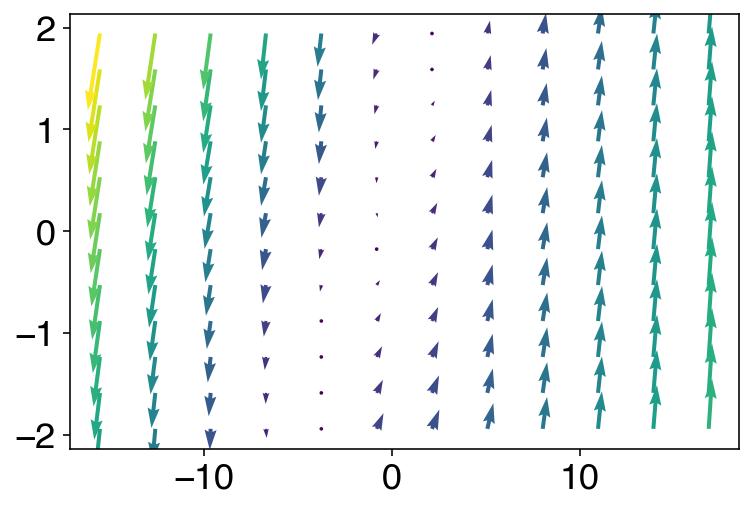

In [1]:
import main, toy, param, utils
%config InlineBackend.figure_format = 'retina'

data_id = 1
estimate_id = 1
seed = 0

# Generate trajectory data

toy.bead_spring(data_id, n_sample=10**5, dim=2, dt=10**(-3),
                T_ratio=0.1,   # T_ratio = 1 is the equilibrium limit
                m_error=0,     # Measurement error (m_error specifies the std of the white noise)
                rand_seed=seed    #Ensure the reproducibility
                )

               
# Edit param 
param.stationary = True
param.dim = 2
param.dt = 10**(-3)
param.n_traj = 1
param.which_model = "FNN"

# Main program
main.estimate_entropy(data_id, estimate_id, rand_seed=seed)

with open('Result/epr' + str(data_id) + '_' + str(estimate_id) + '.txt') as f:
    print('Estimated entropy production rate : ' + str(f.read()) + '\n')

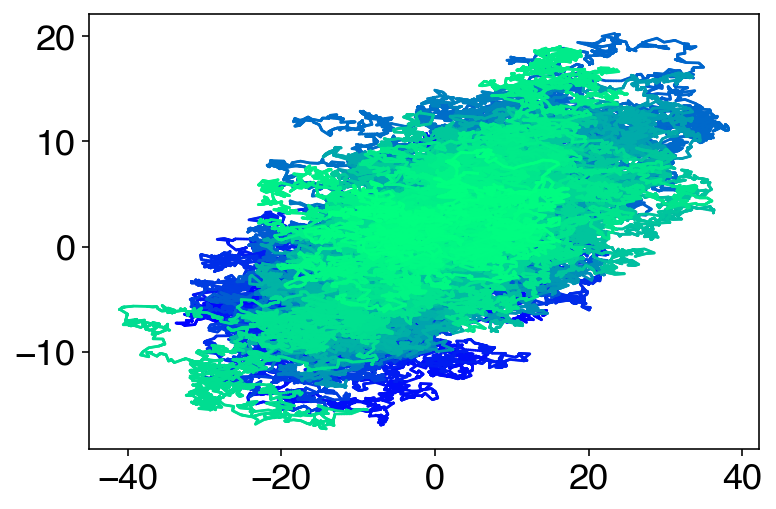

In [2]:
# Plot the trajectory
utils.plot_trajectory('Data/data' + str(data_id) + '.txt')

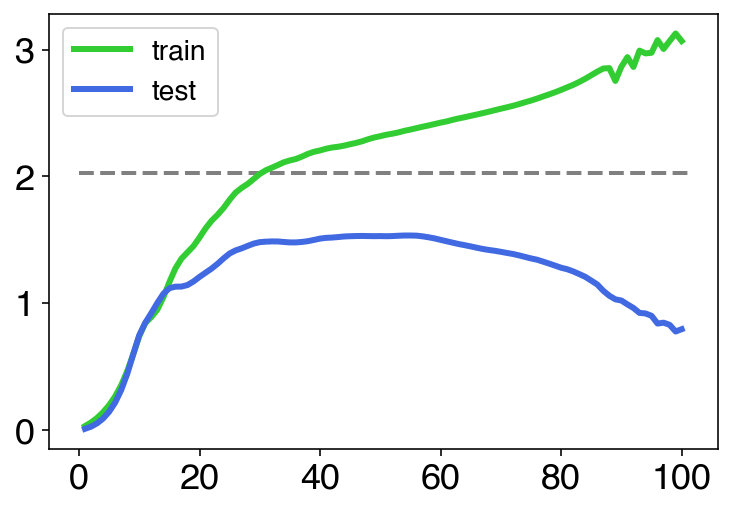

In [3]:
# Plot the learning curve
utils.plot_learning_curve(
    'Result/train' + str(data_id) + '_' + str(estimate_id) + '.txt',
    'Result/test' + str(data_id) + '_' + str(estimate_id) + '.txt',
    true_value = 2.025
)

In [4]:
'''
We also prepare the Mexican hat potential model. Please try if you are interested.

Note : 
    (i) dt should be smaller than 10**(-4)
    (ii) True entropy production rate is
        2.025 (nonlinear=0)
        0.883 (nonlinear=0.01)
        7.86   (nonlinear=1)
        182    (nonlinear=100)
    
See Ref. [1] for more details.
'''

# Please get back to the above, after you run this code. 
# Remember to set param.dt=10**(-4), data_id=2, and comment out toy.bead_spring()

toy.Mexican_hat(data_id=2, n_sample=10**5, dt=10**(-4),    # dim is fixed to 2
                nonlinear=100,    # Nonlinearity of the model
                m_error=0,
                rand_seed=seed
               )

## 2. Code Overview

In this part, we overview the code by looking main.estimate_entropy( ) in detail.

### 2. 1. Setup for the program

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys, time, copy, os
import param, utils, models

data_id = 1
estimate_id = 1
seed = 0
torch.manual_seed(seed)

# Generate trajectory data
toy.bead_spring(data_id, n_sample=10**5, dim=2, dt=10**(-3),
                T_ratio=0.1,   # T_ratio = 1 is the equilibrium limit
                m_error=0,     # Measurement error (m_error specifies the std of the white noise)
                rand_seed=seed    #Ensure the reproducibility
               )

# Edit param
param.stationary = True
param.dim = 2
param.dt = 10**(-3)
param.n_traj = 1

True entropy production rate : 2.0250


In [6]:
'''
The code hereafter is equivalent to "main.estimate_entropy(data_id, estimate_id, rand_seed=seed)"
'''

# Read the data file
data = utils.read_data_file('Data/data' + str(data_id) + '.txt')
train_data, test_data = np.array_split(data, 2, 1)

print(data)
print(data.shape) # Note: the first index is irrelevant here, but it specifies the time instance for the non-stationary case.

tensor([[[-14.5981,  -4.1389,  -0.5710,  -0.0171],
         [-14.6579,  -4.1686,   0.4514,  -0.0423],
         [-14.1664,  -4.2475,   0.5318,  -0.1154],
         ...,
         [  3.7727,   6.9428,  -0.0497,   0.1517],
         [  4.0777,   7.0294,   0.6595,   0.0214],
         [  4.9812,   6.9987,   1.1476,  -0.0828]]])
torch.Size([1, 100000, 4])


**Comment**<br>
The program reads and preprocesses the data file.
The variable *data* holds an ensemble of single-step transitions as

$$\left[\left[\frac{x_0 + x_{m\Delta t}}{2}, \frac{y_0 + y_{m\Delta t}}{2}, x_{m\Delta t} - x_{0}, y_{m\Delta t} - y_{0}\right],
\left[\frac{x_{n\Delta t} + x_{(n+m)\Delta t}}{2}, \frac{y_{n\Delta t} + y_{(n+m)\Delta t}}{2}, x_{(n+m)\Delta t} - x_{n\Delta t}, y_{(n+m)\Delta t} - y_{n\Delta t}\right], ...\right] ,$$

where $m$ is the current interval (*param.current_interval*), $n$ is the slice interval (*param.slice_interval*), and the trajectory index is omitted here for simplicity.

**Tips for coding**<br>
You should not use *for statement* for large size arrays in Python to save the computation time.
For example, *data* is obtained in *utils.read_data_file* as follows.

In [7]:
##  utils.read_data_file() is explained here

raw_data = np.array([1, 2, 1, 4, 1, 6, 1, 8, 1, 10]).reshape(1, -1)
print(raw_data) # Let's regard raw_data as the trajectory data here (only y changes in time)
print('Size' + str(raw_data.shape))
print()

mid_pos = (raw_data[:, :-param.dim*param.current_interval] + raw_data[:, param.dim*param.current_interval:])/2
mid_pos = mid_pos.reshape(1, -1, param.dim)
print(mid_pos)
print('Size' + str(mid_pos.shape))
print()

disp = raw_data[:, param.dim*param.current_interval:] - raw_data[:, :-param.dim*param.current_interval]
disp = disp.reshape(1, -1, param.dim)
print(disp)
print('Size' + str(disp.shape))
print()

tmp_data = np.concatenate([mid_pos, disp], 2).reshape(1, -1, param.dim*2)
print(tmp_data)
print('Size' + str(tmp_data.shape))

[[ 1  2  1  4  1  6  1  8  1 10]]
Size(1, 10)

[[[1. 3.]
  [1. 5.]
  [1. 7.]
  [1. 9.]]]
Size(1, 4, 2)

[[[0 2]
  [0 2]
  [0 2]
  [0 2]]]
Size(1, 4, 2)

[[[1. 3. 0. 2.]
  [1. 5. 0. 2.]
  [1. 7. 0. 2.]
  [1. 9. 0. 2.]]]
Size(1, 4, 4)


In [8]:
# Initialize the model function
param.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Assign CUDA if it runs on a GPU machine
model_func = models.FNN()
model_func.to(param.device)
optim = torch.optim.Adam(model_func.parameters(), param.alpha) # The algorithm called Adam is used for the gradient ascent

**Comment**<br>
The program initializes the feedforward neural network, and *model_func* holds its instance.
*model_func* represents the coefficient ${\boldsymbol d}({\boldsymbol x}|{\boldsymbol\theta})$ of the optimizing current (or the generalized current),
and *optim* will perform the gradient ascent on the parameters $\boldsymbol \theta$. The definition of the *FNN* is as follows.

In [9]:
## models.FNN is explained here

import torch
import torch.nn as nn
import param

class FNN(nn.Module):
    '''                                                                                                                            
    Feedforward neural network for the coefficient d(x)                                                                            
    Input:  position                                                                                                               
    Output: coefficient                                                                                                            
                                                                                                                                   
    The input can be an array of (x), i.e., (dim, n_data) tensor.                                                                  
    Then, the output becomes an array of (d), i.e., (dim, n_data) tensor.                                                          
    '''
    # Define the modules that constitute the network
    def __init__(self):
        super(FNN, self).__init__()
        self.n_layer = param.n_layer
        tmp = nn.Sequential()
        tmp.add_module("fc", nn.Linear(param.dim, param.n_hidden))
        tmp.add_module("relu", nn.ReLU(inplace=True))
        setattr(self, "layer1", tmp)
        for i in range(param.n_layer-1):
            tmp = nn.Sequential()
            tmp.add_module("fc", nn.Linear(param.n_hidden, param.n_hidden))
            tmp.add_module("relu", nn.ReLU(inplace=True))
            setattr(self, "layer%d" % (i+2), tmp)
        self.out = nn.Linear(param.n_hidden, param.dim)

    # Define the network by connecting the modules
    def forward(self, s, correct=1):
        '''                                                                                                                        
        argument s = (x)                                                                                                           
        correct is for cancelling the constant factor when the short-time TUR is used                                              
        '''
        for i in range(self.n_layer):
            f = getattr(self, "layer%d" % (i+1))
            s = f(s)
        return self.out(s) / correct
    
#You can create instances of the network as follows
net1 = FNN()
net2 = FNN()

#Forward pass calculation. net1 and net2 give different values since they are independent networks with different initial parameters.
s = torch.tensor([0.3, 0.7])
print(net1(s))
print(net2(s))

tensor([0.0450, 0.0665], grad_fn=<DivBackward0>)
tensor([0.0762, 0.1249], grad_fn=<DivBackward0>)


### 2. 2. Train the model function

Next, we explain how to train the model function.

In [10]:
best_score = -10**3  # any large negative value is fine                                                                      
best_step  = 0
best_state = copy.deepcopy(model_func.state_dict())
f_train = open('Result/train' + str(data_id) + '_' + str(estimate_id) + '.txt', mode='w')
f_test = open('Result/test' + str(data_id) + '_' + str(estimate_id) + '.txt', mode='w')

for i in range(param.n_gradient_ascent):
    train_value = utils.train(model_func, train_data, optim) # the gradient ascent is performed using train_data
    test_value = utils.validate(model_func, test_data) # the model_func is evaluated using test_data
    f_train.write(str(train_value) + ' ')
    f_train.flush()
    f_test.write(str(test_value) + ' ')
    f_test.flush()
    if test_value > best_score:  # if the test_value is the highest, the state of the model_func is recorded.
        best_state = copy.deepcopy(model_func.state_dict())
        best_score = test_value
        best_step  = i+1
 
torch.save(best_state, 'Result/model_state' + str(data_id) + '_' + str(estimate_id) + '.txt')
f_train.close()
f_test.close()

In [11]:
## utils.train() and utils.validate() are explained here

def obj_func(model_func, data, coeff):
    if param.stationary:
        # For the stationary case, s = (x)                                                                                     
        s  = data[:, :, :param.dim]
        dx = data[:, :, param.dim:]
    else:
        # For the non-stationary case, s = (t x)                                                                               
        s  = data[:, :, :param.dim+1]
        dx = data[:, :, param.dim+1:]

    cur = (model_func(s) * dx).sum(2) 
    print('Array of the optimizing current :\n     ' + str(cur))
    print('Size : ' + str(cur.shape))
    print()
    
    if param.which_rep == "Simple":
        ret = torch.matmul(coeff, 2*torch.mean(cur, 1) - torch.var(cur, 1)/2) / (param.dt*param.current_interval)
    elif param.which_rep == "NEEP":
        ret = torch.matmul(coeff, torch.mean(cur-torch.exp(-cur)+1, 1)) / (param.dt*param.current_interval)
    elif param.which_rep == "TUR":
        ret =  torch.matmul(coeff, 2*torch.mean(cur, 1)**2/torch.var(cur, 1)) / (param.dt*param.current_interval)  
    print('Objective function :\n     ' + str(ret))
    print()
    return ret

        
def train(model_func, train_data, optim):
    '''                                                                                                                        
    This function performs the gradient ascent using training data,                                                              
    and returns the value of the objective function.                                                                           
    '''
    # coeff is irrelevant for the stationary case, and simply coeff = [[1]]
    coeff = np.random.uniform(0, 1, len(train_data)).reshape(1, -1)
    coeff /= coeff.sum()
    coeff = torch.from_numpy(coeff).to(param.device).float()

    model_func.train()
    loss = -obj_func(model_func, train_data, coeff)  # Minus sign is added so that it becomes the loss function
    optim.zero_grad()  # Erase the past gradient
    loss.backward()      # Calculate the gradient for the parameters
    optim.step()           # Parameters are updated on the basis of the gradient
    return float(-loss)

print('Training value : ' + str(train(model_func, train_data, optim)))
print()


def validate(model_func, data):
    '''                                                                                                                        
    This function evaluates the model function using training or test data,                                                    
    and returns an estimate of the time-averaged entropy production rate.                                                      
    '''
    coeff = (np.ones(len(data))/len(data)).reshape(1, -1)
    coeff = torch.from_numpy(coeff).to(param.device).float()
    model_func.eval()
    return float(obj_func(model_func, data, coeff))

print('Test value : ' + str(validate(model_func, test_data)))

Array of the optimizing current :
     tensor([[ 0.0213, -0.0235, -0.0350,  ...,  0.0032, -0.0119, -0.0249]],
       grad_fn=<SumBackward1>)
Size : torch.Size([1, 50000])

Objective function :
     tensor([3.1572], grad_fn=<DivBackward0>)

Training value : 3.1571707725524902

Array of the optimizing current :
     tensor([[-0.0406,  0.0560, -0.0752,  ...,  0.0032,  0.0213,  0.0256]],
       grad_fn=<SumBackward1>)
Size : torch.Size([1, 50000])

Objective function :
     tensor([0.7851], grad_fn=<DivBackward0>)

Test value : 0.7850813865661621


### 2. 3. Estimate the entropy production rate

After the training, the entropy production rate can be estimated simply as follows.

In [12]:
# Load the trained model_func
model_func.load_state_dict(torch.load('Result/model_state' + str(data_id) + '_' + str(estimate_id) + '.txt', map_location=param.device))
model_func.eval()

with torch.no_grad():  # This declaration stops the internal calculation of the gradient
    epr = utils.estimate_epr(model_func, test_data[0])                            
    print('entropy production rate : ' + str(float(epr)))    

entropy production rate : 1.534157395362854


In [13]:
## utils.estimate_epr() is explained here

def estimate_epr(model_func, data_inst):
    '''                                                                                                                        
    data_inst is an ensemble of single-step transitions at a particular time of interest                                     
    '''
    if param.stationary:
        # For the stationary case, s = (x)                                                                                     
        s  = data_inst[:, :param.dim]
        dx = data_inst[:, param.dim:]
    else:
        # For the non-stationary case, s = (t x)                                                                               
        s  = data_inst[:, :param.dim+1]
        dx = data_inst[:, param.dim+1:]

    cur = (model_func(s) * dx).sum(1)
    
    '''
    In addition to the variational representations, the variance of the optimizing current can be used
    as an estimator of the entropy production rate if the model_func directly estimates the thermodynamic force,
    i.e., unless which_rep == "TUR".
    
    The variance based estimation can decrease the statistical error for the non-stationary case.
    '''
    if param.which_estimator == "Simple":
        return (2*cur.mean()-cur.var()/2) / (param.dt*param.current_interval)
    elif param.which_estimator == "NEEP":
        return (cur-torch.exp(-cur)+1).mean() / (param.dt*param.current_interval)
    elif param.which_estimator == "TUR":
        return 2*cur.mean()**2/cur.var() / (param.dt*param.current_interval)
    elif param.which_estimator == "Var":
        return cur.var()/2 / (param.dt*param.current_interval)

That's all. We skip the explanation of the thermodynamic force drawing here, since it is understandable similarly to the above. See main.py for the implementation.

## 3. Advanced topics

### 3. 1. Hyperparameter tuning

Hyperparameters are the parameters of a network which should be determined before the gradient ascent.
For example, the number of hidden layers (*param.n_layer*) and the number of units per hidden layer (*param.n_hidden*) are the hyperparameters of the *FNN*. <br>
&emsp;We show a sketch of the *FNNt* (the *FNN* is the version without $t$ in the input layer) below. In this sketch, the network has three hidden layers, and has five units per hidden layer.

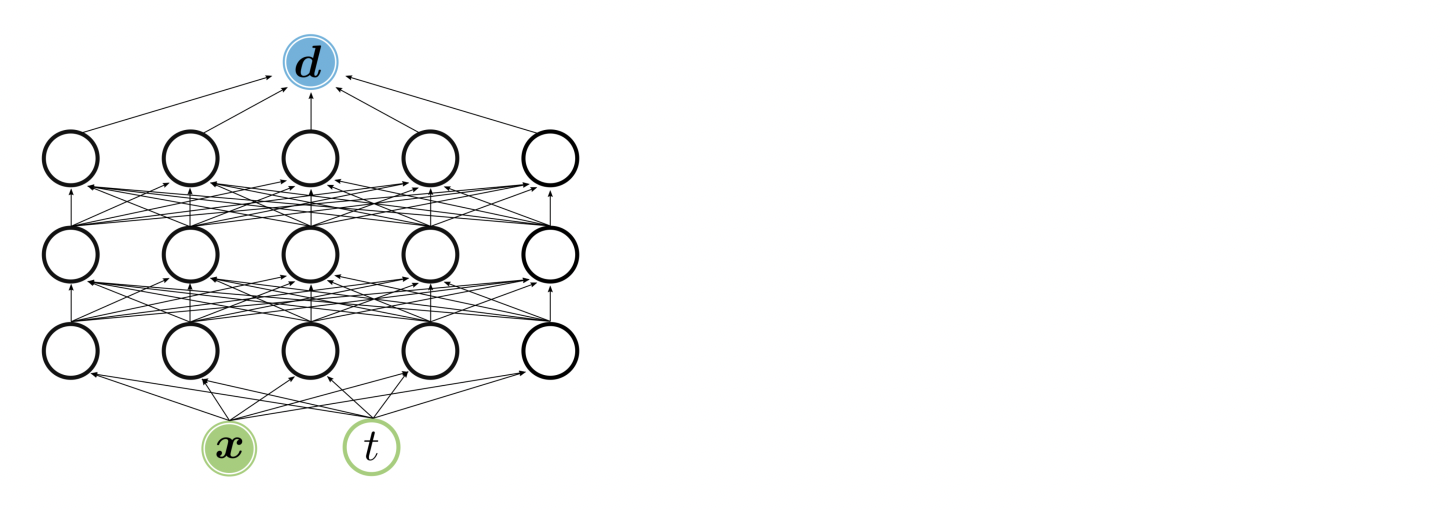

In [14]:
from PIL import Image
im = Image.open('pic/FNNt.png')
im

In the following, we show results with three hyperparameter sets : (param.n_layer, param.n_hidden) = (1, 10), (2, 20), (3, 30).
The test value becomes the largest when the hyperparameters are optimal.<br>
&emsp;In practice, it is important to check the underfitting case first, for example, with (param.n_layer, param.n_hidden) = (1, 1).
In this limit, the training and test values should be close to each other.
If those values are far apart, a reasonable estimation is unlikely even if you increase the network complexity.

In [15]:
'''
Preparation
'''
import main, toy, param, utils
%config InlineBackend.figure_format = 'retina'

data_id = 2
estimate_id = 1
seed = 0

# Generate trajectory data
toy.Mexican_hat(data_id, n_sample=10**4, dt=10**(-4),
                nonlinear=100,    # Nonlinearity of the model
                m_error=0,
                rand_seed=seed
               )

# Edit param
param.stationary = True
param.dim = 2
param.dt = 10**(-4)
param.n_traj = 1
param.which_model = "FNN"
param.which_rep = "Simple"
param.which_estimator = "Simple"
param.n_gradient_ascent = 1000

Estimated entropy production rate : 71.947449 



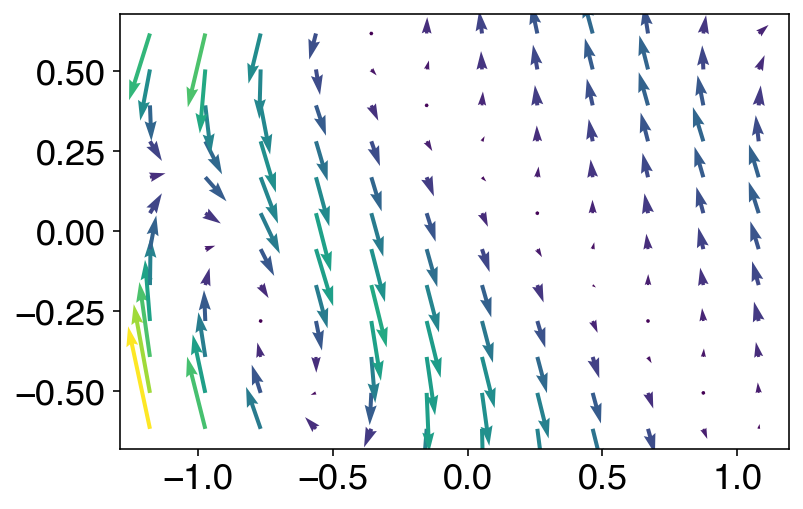

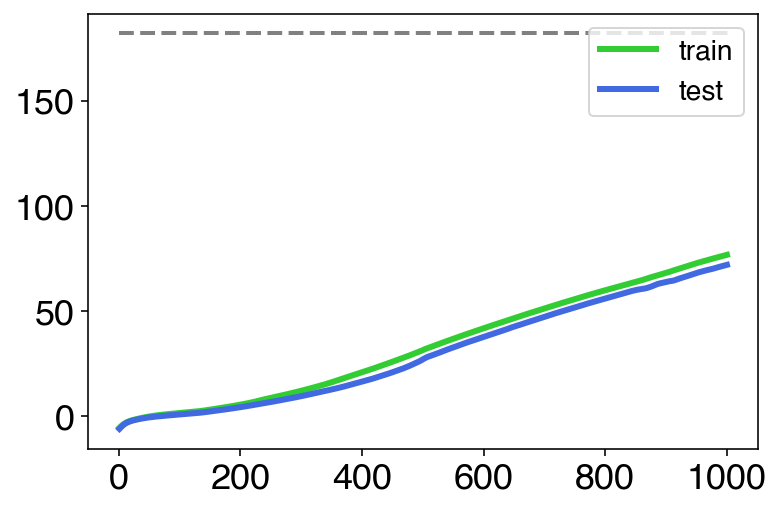

In [16]:
'''
Underfitting
'''
param.n_layer = 1
param.n_hidden = 10

main.estimate_entropy(data_id, estimate_id, rand_seed=seed)

utils.plot_learning_curve(
    'Result/train' + str(data_id) + '_' + str(estimate_id) + '.txt',
    'Result/test' + str(data_id) + '_' + str(estimate_id) + '.txt',
    true_value = 182
)

with open('Result/epr' + str(data_id) + '_' + str(estimate_id) + '.txt') as f:
    print('Estimated entropy production rate : ' + str(f.read()) + '\n')

Estimated entropy production rate : 135.176727 



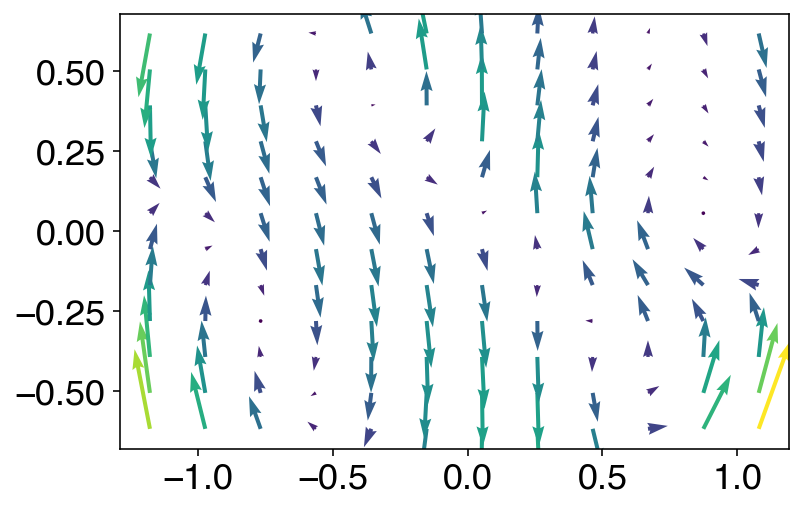

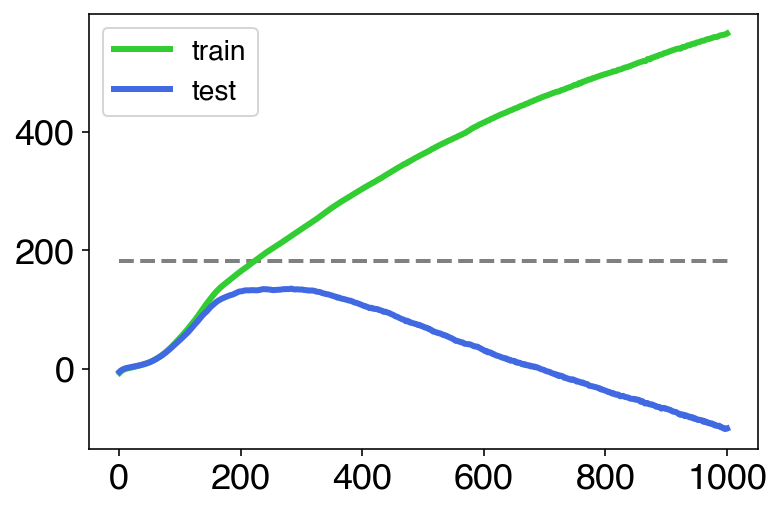

In [17]:
'''
Overfitting
'''
param.n_layer = 3
param.n_hidden = 30

main.estimate_entropy(data_id, estimate_id, rand_seed=seed)

utils.plot_learning_curve(
    'Result/train' + str(data_id) + '_' + str(estimate_id) + '.txt',
    'Result/test' + str(data_id) + '_' + str(estimate_id) + '.txt',
    true_value = 182
)

with open('Result/epr' + str(data_id) + '_' + str(estimate_id) + '.txt') as f:
    print('Estimated entropy production rate : ' + str(f.read()) + '\n')

Estimated entropy production rate : 163.238571 



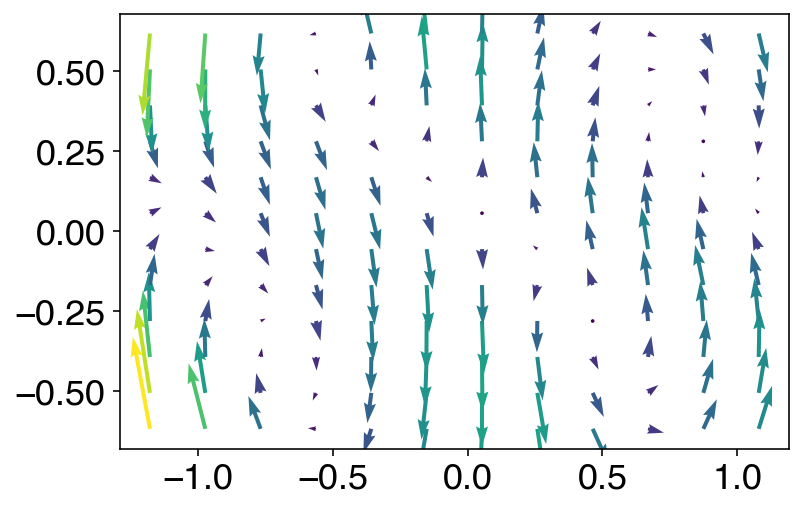

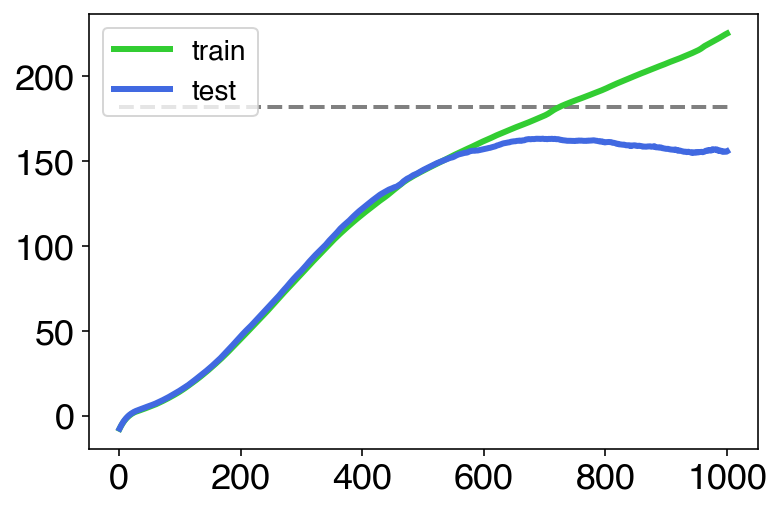

In [18]:
'''
Best case. The test value becomes the largest.
'''
param.n_layer = 2
param.n_hidden = 20

main.estimate_entropy(data_id, estimate_id, rand_seed=seed)

utils.plot_learning_curve(
    'Result/train' + str(data_id) + '_' + str(estimate_id) + '.txt',
    'Result/test' + str(data_id) + '_' + str(estimate_id) + '.txt',
    true_value = 182
)

with open('Result/epr' + str(data_id) + '_' + str(estimate_id) + '.txt') as f:
    print('Estimated entropy production rate : ' + str(f.read()) + '\n')

### 3. 2. Time interval dependence

The time interval of the optimizing current (*param.current_interval*) affects the estimation results, especially when there is a measurement error.
If the time interval is too small, it is vulnerable to the measurement noise.
On the other hand, if the time interval is too large, the short-time condition of a variational representation is violated. 
In the both cases, the estimate becomes lower than the true value.
Therefore, this is a tradeoff relation similar to the underfitting-overfitting tradeoff, and the optimal time interval can be determined simply by comparing the test values.

In [19]:
'''
Preparation
'''
import main, toy, param, utils
%config InlineBackend.figure_format = 'retina'

data_id = 1
estimate_id = 1
seed = 0

# Generate trajectory data
toy.bead_spring(data_id, n_sample=10**5, dim=2, dt=10**(-3),
                T_ratio=0.1,   # T_ratio = 1 is the equilibrium limit
                m_error=1,     # Measurement error (m_error specifies the std of the white noise)
                rand_seed=seed    #Ensure the reproducibility
               )

# Edit param
param.stationary = True
param.dim = 2
param.dt = 10**(-3)
param.n_traj = 1
param.which_model = "FNN"
param.which_rep = "TUR"
param.which_estimator = "TUR"
param.n_gradient_ascent = 100

True entropy production rate : 2.0250


Estimated entropy production rate : 0.830513 



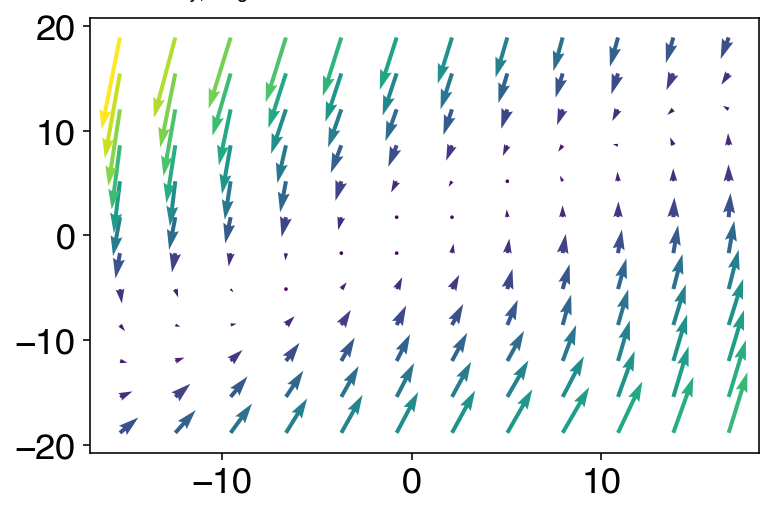

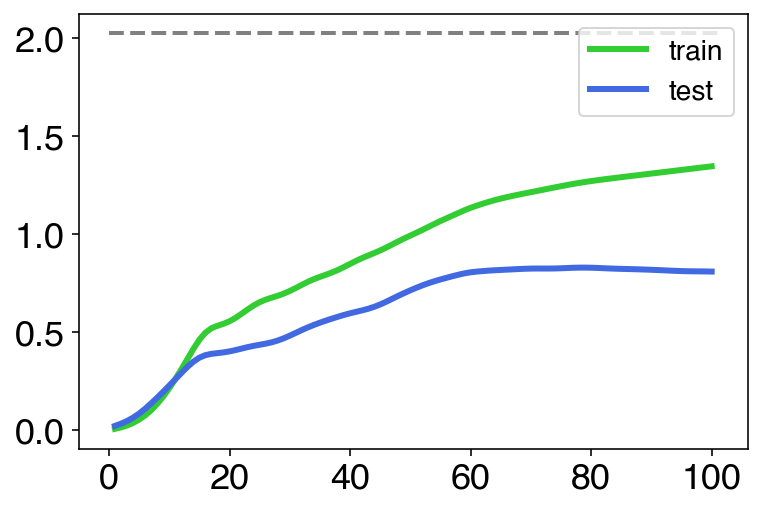

In [20]:
'''
Please change param.current_interval from 1 to 1000
'''
param.current_interval = 100
main.estimate_entropy(data_id, estimate_id, rand_seed=seed)

utils.plot_learning_curve(
    'Result/train' + str(data_id) + '_' + str(estimate_id) + '.txt',
    'Result/test' + str(data_id) + '_' + str(estimate_id) + '.txt',
    true_value = 2.025
)

with open('Result/epr' + str(data_id) + '_' + str(estimate_id) + '.txt') as f:
    print('Estimated entropy production rate : ' + str(f.read()) + '\n')